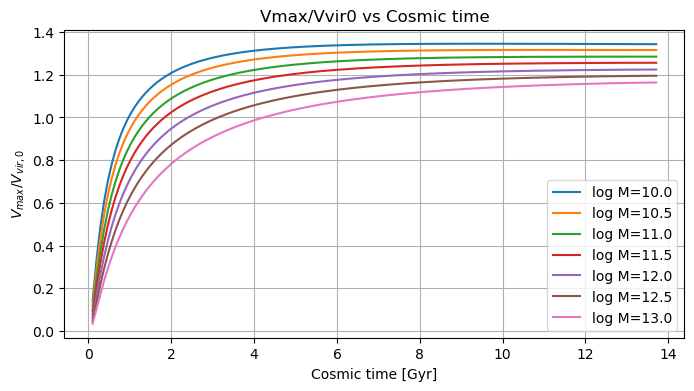

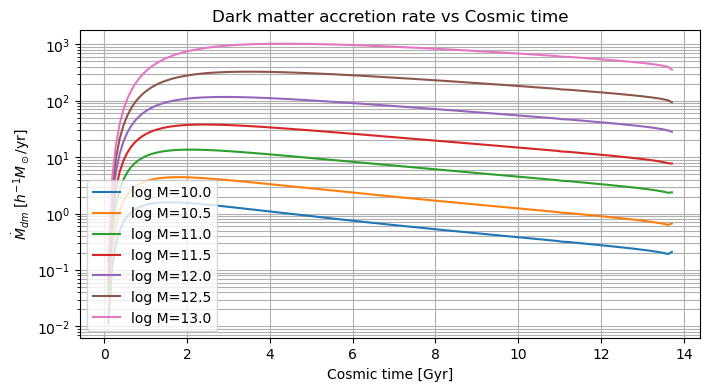

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


t0 = 13.8  # age of the Universe [Gyr]
data_dir = "pwgh/"  # folder with PWGH_average_MXX.dat files
halo_masses = np.arange(10, 13.5, 0.5)  # 10 to 13 in 0.5 steps
ti = np.linspace(0.1, t0, 150)

def load_pwgh(filename):
    df = pd.read_csv(filename, delim_whitespace=True, comment="#", header=None)
    t_lb = df.iloc[:, 2].values       #lookback time [Gyr]
    log_v = df.iloc[:, 5].values      #log10(Vmax/Vvir0)
    mdot = df.iloc[:, 7].values       #Mdot_dm [h^-1 Msun/yr]
    t = t0 - t_lb                     #cosmic time
    vratio = 10**log_v
    return t, vratio, mdot

def interp(x, y, xi):
    return np.interp(xi, np.sort(x), y[np.argsort(x)], left=np.nan, right=np.nan)

plt.figure(figsize=(8,4))
for M in halo_masses:
    fname = os.path.join(data_dir, f"PWGH_average_M{M:.1f}.dat")
    t, vratio, mdot = load_pwgh(fname)
    plt.plot(ti, interp(t, vratio, ti), label=f"log M={M:.1f}")
plt.xlabel("Cosmic time [Gyr]")
plt.ylabel(r"$V_{max}/V_{vir,0}$")
plt.legend()
plt.grid(True)
plt.title("Vmax/Vvir0 vs Cosmic time")
plt.show()

plt.figure(figsize=(8,4))
for M in halo_masses:
    fname = os.path.join(data_dir, f"PWGH_average_M{M:.1f}.dat")
    t, vratio, mdot = load_pwgh(fname)
    plt.plot(ti, interp(t, mdot, ti), label=f"log M={M:.1f}")
plt.xlabel("Cosmic time [Gyr]")
plt.ylabel(r"$\dot M_{dm}$ [$h^{-1} M_\odot$/yr]")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both")
plt.title("Dark matter accretion rate vs Cosmic time")
plt.show()


Mvir = 14285714285.714287
Mvir = 45175395145.262566
Mvir = 142857142857.14285
Mvir = 451753951452.6257
Mvir = 1428571428571.4287
Mvir = 4517539514526.257
Mvir = 14285714285714.287
[0.11121501 0.10375618 0.10706619 0.09930036 0.06875343 0.0356192
 0.03181918]


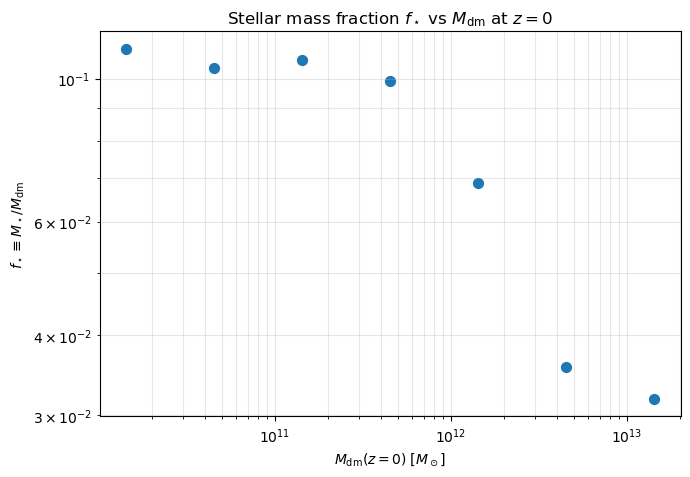

Mdm(0)= 1.429e+10 Msun | Mstar(0)= 1.589e+09 Msun | f*= 1.112e-01 
Mdm(0)= 4.518e+10 Msun | Mstar(0)= 4.687e+09 Msun | f*= 1.038e-01 
Mdm(0)= 1.429e+11 Msun | Mstar(0)= 1.530e+10 Msun | f*= 1.071e-01 
Mdm(0)= 4.518e+11 Msun | Mstar(0)= 4.486e+10 Msun | f*= 9.930e-02 
Mdm(0)= 1.429e+12 Msun | Mstar(0)= 9.822e+10 Msun | f*= 6.875e-02 
Mdm(0)= 4.518e+12 Msun | Mstar(0)= 1.609e+11 Msun | f*= 3.562e-02 
Mdm(0)= 1.429e+13 Msun | Mstar(0)= 4.546e+11 Msun | f*= 3.182e-02 


In [3]:

h  = 0.7                          # dimensionless Hubble parameter
fb = 0.18                         # cosmic baryon fraction
R  = 0.4                          # return fraction
A  = 2e-10                        # SFR law: SFR = A * M_g  [Msun/yr], M_g in Msun
Mcrit = 6e11                      # critical mass [Msun]

dt = np.diff(ti, prepend=ti[0])

def gamma_cool(Mdm):
    g = np.ones_like(Mdm)
    g[Mdm > Mcrit] = 0.3
    return g

Mdm0_list, Mstar0_list = [], []
for Mlog in halo_masses:
    fn = os.path.join(data_dir, f"PWGH_average_M{Mlog:.1f}.dat")
    t_raw, vratio_raw, mdot_dm_hinv = load_pwgh(fn)
    mdot_dm_hinv_i = interp(t_raw, mdot_dm_hinv, ti)        # [h^-1 Msun/yr]
    if np.all(np.isnan(mdot_dm_hinv_i)):           #skip bad files
        continue
    mdot_dm = mdot_dm_hinv_i / h                            # [Msun/yr]
    Mvir0    = (10**Mlog) / h                               # target DM mass at z=0 [Msun]

    #rebuild M_dm(t) by integrating Mdot and renormalize to hit Mvir0 at t0
    Mdm = np.zeros_like(ti)
    for i in range(1, len(ti)):
        #Euler integrate: Mdm += mdot * dt
        Mdm[i] = Mdm[i-1] + mdot_dm[i-1] * dt[i] * 1e9
    if Mdm[-1] > 0:
        C = Mvir0 - Mdm[-1]
        Mdm = Mdm + C

    #cool
    Macc_g = gamma_cool(Mdm) * fb * mdot_dm                 # [Msun/yr]

    # euler for Mg, Mstar, SFR
    Mg    = np.zeros_like(ti)                               # gas mass [Msun]
    Mstar = np.zeros_like(ti)                               # stellar mass [Msun]
    SFR   = np.zeros_like(ti)                               # [Msun/yr]

    for i in range(len(ti)-1):
        SFR[i] = A * Mg[i]
        dMg   = (Macc_g[i] - (1.0 - R) * SFR[i]) * 1e9 * dt[i+1]
        dMs   = ((1.0 - R) * SFR[i]) * 1e9 * dt[i+1]
        Mg[i+1]    = max(Mg[i] + dMg, 0.0)                  # no negative gas
        Mstar[i+1] = max(Mstar[i] + dMs, 0.0)

    # final SFR for completeness (not used below)
    SFR[-1] = A * Mg[-1]

    # store z=0 values
    Mdm0_list.append(Mdm[-1])
    Mstar0_list.append(Mstar[-1])
    print(f"Mvir = {Mvir0}") #debugging

if len(Mdm0_list) == 0:
    print("No halos processed. Make sure your PWGH files are in:", data_dir)
else:
    Mdm0_arr   = np.array(Mdm0_list)
    Mstar0_arr = np.array(Mstar0_list)
    fstar      = Mstar0_arr / Mdm0_arr

    plt.figure(figsize=(7.5,5))
    plt.scatter(Mdm0_arr, fstar, s=50)
    print(fstar)
    plt.xscale("log")
    plt.yscale("log")
    #plt.ylim(0, max(1e-1, np.nanmax(fstar)*1.2))
    #plt.ylim( 0.0001, 1)
    plt.xlabel(r"$M_{\rm dm}(z{=}0)\;[M_\odot]$")
    plt.ylabel(r"$f_\star \equiv M_\star/M_{\rm dm}$")
    plt.title(r"Stellar mass fraction $f_\star$ vs $M_{\rm dm}$ at $z=0$")
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

    for Mdm0, Ms0, fs in zip(Mdm0_arr, Mstar0_arr, fstar):
        print(f"Mdm(0)={Mdm0: .3e} Msun | Mstar(0)={Ms0: .3e} Msun | f*={fs: .3e} ")


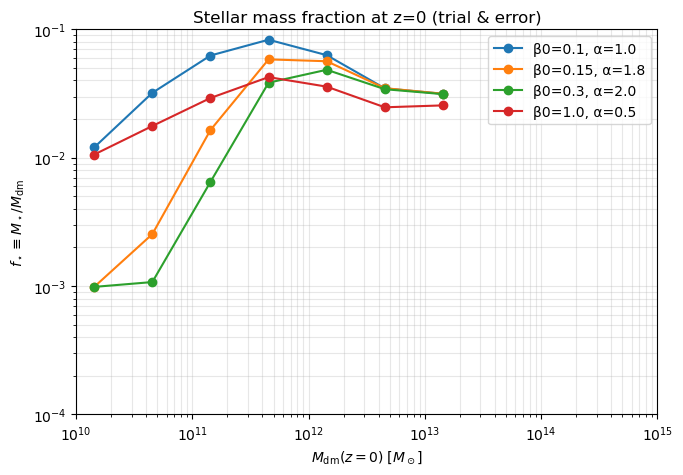

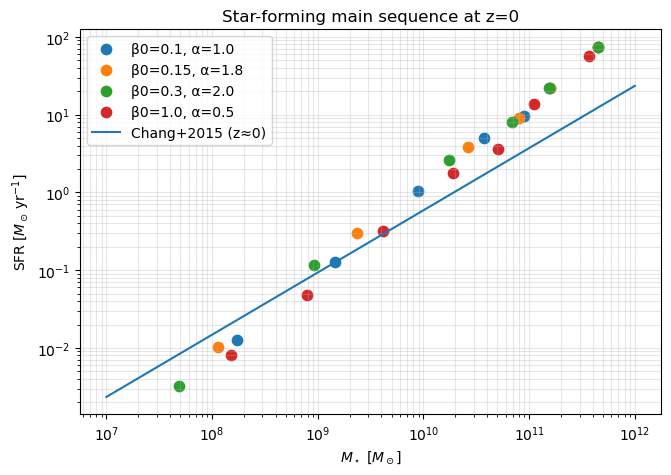

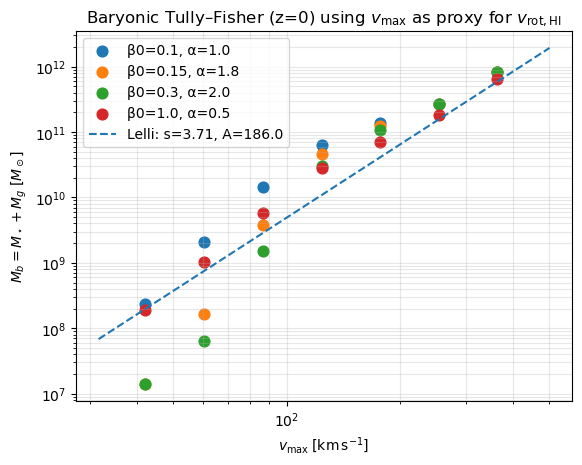


Params: beta0=0.1, alpha=1.0
  Mdm= 1.429e+10  M*= 1.720e+08  f*= 1.204e-02  SFR= 1.250e-02
  Mdm= 4.518e+10  M*= 1.448e+09  f*= 3.205e-02  SFR= 1.277e-01
  Mdm= 1.429e+11  M*= 8.945e+09  f*= 6.261e-02  SFR= 1.054e+00
  Mdm= 4.518e+11  M*= 3.756e+10  f*= 8.313e-02  SFR= 5.052e+00
  Mdm= 1.429e+12  M*= 9.001e+10  f*= 6.301e-02  SFR= 9.498e+00
  Mdm= 4.518e+12  M*= 1.570e+11  f*= 3.475e-02  SFR= 2.193e+01
  Mdm= 1.429e+13  M*= 4.500e+11  f*= 3.150e-02  SFR= 7.393e+01

Params: beta0=0.15, alpha=1.8
  Mdm= 1.429e+10  M*= 1.408e+07  f*= 9.858e-04  SFR= 0.000e+00
  Mdm= 4.518e+10  M*= 1.148e+08  f*= 2.541e-03  SFR= 1.043e-02
  Mdm= 1.429e+11  M*= 2.349e+09  f*= 1.644e-02  SFR= 2.978e-01
  Mdm= 4.518e+11  M*= 2.639e+10  f*= 5.842e-02  SFR= 3.827e+00
  Mdm= 1.429e+12  M*= 8.073e+10  f*= 5.651e-02  SFR= 8.998e+00
  Mdm= 4.518e+12  M*= 1.574e+11  f*= 3.484e-02  SFR= 2.219e+01
  Mdm= 1.429e+13  M*= 4.508e+11  f*= 3.156e-02  SFR= 7.430e+01

Params: beta0=0.3, alpha=2.0
  Mdm= 1.429e+10  M*= 1.408

In [4]:
Delta_c0 = 18*np.pi**2 + 82*(-0.7) - 39*(0.7**2)   # ~101.14
# H0, G, M_sun in SI
_MPC_M = 3.085677581491367e22
_H0_SI = 70_000.0 / _MPC_M      # 70 km/s/Mpc -> s^-1
_G_SI  = 6.67430e-11            # m^3 kg^-1 s^-2
_MSUN_KG = 1.98847e30

def _interp_nan(x, y, xi):
    """Linear interpolation that returns NaN outside the data span (for dimensionless ratios)."""
    order = np.argsort(x)
    yi = np.interp(xi, x[order], y[order], left=np.nan, right=np.nan)
    return yi

def interp(x, y, xi):
    order = np.argsort(x)
    yi = np.interp(xi, x[order], y[order], left=np.nan, right=np.nan)
    return np.nan_to_num(yi, nan=0.0)

def gamma_cool(Mdm):
    g = np.ones_like(Mdm)
    g[Mdm > Mcrit] = 0.3
    return g

def beta_mass_loading(Mdm, beta0, alpha):
    return beta0 * (np.maximum(Mdm, 1.0)/Mcrit)**(-alpha)

def _vvir0_kms_from_Mvir0(Mvir0_Msun):
    v_mps = (_G_SI * (Mvir0_Msun * _MSUN_KG) * _H0_SI)**(1/3) * (0.5 * Delta_c0)**(1/6)
    return v_mps / 1000.0

def run_model(beta0, alpha):
    Vmax0_list, Mb0_list, Mdm0_list, Ms0_list, SFR0_list = [], [], [], [], []
    for Mlog in halo_masses:
        fn = os.path.join(data_dir, f"PWGH_average_M{Mlog:.1f}.dat")
        if not os.path.exists(fn):
            continue

        # DM accretion rate -> Msun/yr on uniform grid
        t_raw, logvr, mdot_dm_hinv = load_pwgh(fn)
        #print("grid last =", ti[-1], "  table t max =", np.nanmax(t_raw)) #debugging
        #logvr = np.log(logvr)
        mdot_dm = interp(t_raw, mdot_dm_hinv, ti) / h
        vratio_i = _interp_nan(t_raw, logvr, ti)                
        #vratio_z0 = vratio_i[-1]
        #this whole fix was suggested by chat gpt. the last element of the interpolation is outside the range of ti, which makes it nan
        if np.isfinite(vratio_i[-1]):
            vratio_z0 = vratio_i[-1]
        else:
            finite = np.where(np.isfinite(vratio_i))[0]
            if finite.size:
                vratio_z0 = vratio_i[finite[-1]]  # last finite on your grid
        
        #print(vratio_i) #debugging

        #
        Mvir0 = (10**Mlog) / h  # [Msun]
        Mdm = np.zeros_like(ti)
        for i in range(1, len(ti)):
        #euler
            Mdm[i] = Mdm[i-1] + mdot_dm[i-1] * dt[i] * 1e9
         #renormalize
            if Mdm[-1] > 0:
                C = Mvir0 - Mdm[-1]
                Mdm = Mdm + C
        #gas accretion and feedback
        gamma = gamma_cool(Mdm)
        beta  = beta_mass_loading(Mdm, beta0, alpha)
        Macc_g = gamma * fb * mdot_dm  # [Msun/yr]

        #Euler, enforce Mg >= 0 each step
        Mg    = np.zeros_like(ti)
        Mstar = np.zeros_like(ti)
        SFR   = np.zeros_like(ti)

        for i in range(len(dt)-1):
            SFR[i] = A * Mg[i]
            dMg = (Macc_g[i] - (1.0 - R + beta[i]) * SFR[i]) * 1e9 * dt[i]
            dMs = ((1.0 - R) * SFR[i]) * 1e9 * dt[i]
            Mg[i+1]    = max(Mg[i] + dMg, 0.0)
            Mstar[i+1] = max(Mstar[i] + dMs, 0.0)
        SFR[-1] = A * Mg[-1]

        x = Mstar[-1] + Mg[-1]
        vvir0_kms = _vvir0_kms_from_Mvir0(Mvir0)
        vmax0_kms = vratio_z0 * vvir0_kms

        Vmax0_list.append(vmax0_kms)
        Mb0_list.append(x)

        Mdm0_list.append(Mdm[-1])
        Mstar0_list.append(Mstar[-1])
        SFR0_list.append(SFR[-1])
        Ms0_list.append(Mstar[-1])  #Mstar0 and Ms0 are kind of the same thing, i recycled the code from the last cell and didn't realize

        #print(vratio_z0)

    return (np.array(Vmax0_list), np.array(Mb0_list),
            np.array(Mdm0_list), np.array(Ms0_list), np.array(SFR0_list))


param_pairs = [
    
    (0.10, 1.0),
    (0.15, 1.8),
    (0.30, 2.0),
    (1.00, 0.5)
]

#plot
results = []
for beta0, alpha in param_pairs:
    V0, Mb0, Mdm0_btfr, Ms0_btfr, SFR0_btfr = run_model(beta0, alpha)
    order = np.argsort(V0)
    results.append({
        "beta0": beta0, "alpha": alpha,
        "V": V0[order], "Mb": Mb0[order],
        "Mdm0": Mdm0_btfr[order], "Mstar0": Ms0_btfr[order], "SFR0": SFR0_btfr[order]
    })

# (1) f_star vs M_dm at z=0
plt.figure(figsize=(7.5,5))
for r in results:
    fstar = r["Mstar0"] / r["Mdm0"]
    plt.plot(r["Mdm0"], fstar, marker="o", label=f"β0={r['beta0']}, α={r['alpha']}")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4, 0.1)
plt.xlim(10e+9, 10e+14)
#plt.ylim(1e-4, max(0.1, max((r["Mstar0"]/r["Mdm0"]).max() for r in results)*1.4))
plt.xlabel(r"$M_{\rm dm}(z{=}0)\;[M_\odot]$")
plt.ylabel(r"$f_\star \equiv M_\star/M_{\rm dm}$")
plt.title("Stellar mass fraction at z=0 (trial & error)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()

#Main sequence at z=0 + Chang2015
plt.figure(figsize=(7.5,5))
for r in results:
    plt.scatter(r["Mstar0"], r["SFR0"], s=55, label=f"β0={r['beta0']}, α={r['alpha']}")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$M_\star\;[M_\odot]$")
plt.ylabel(r"$\mathrm{SFR}\;[M_\odot\,\mathrm{yr}^{-1}]$")
#Chang2015 line: log SFR = 0.8 * log(M*/1e10) - 0.23
Mline = np.logspace(7, 12, 200)
SFR_line = 10**(0.8*(np.log10(Mline) - 10.0) - 0.23)
plt.plot(Mline, SFR_line, label="Chang+2015 (z≈0)")
plt.title("Star-forming main sequence at z=0")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()

s_lelli  = 3.71
A_lelli  = 186.0

for r in results:
    plt.scatter(r["V"], r["Mb"], s=60, label=f"β0={r['beta0']}, α={r['alpha']}")
V_line = np.logspace(1.5, 2.7, 200)  # ~30 to 500 km/s
Mb_line = A_lelli * V_line**s_lelli
plt.plot(V_line, Mb_line, linestyle="--", label=f"Lelli: s={s_lelli}, A={A_lelli}")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$v_{\max}\;[\mathrm{km\,s^{-1}}]$")
plt.ylabel(r"$M_b=M_\star+M_g\;[M_\odot]$")
plt.title(r"Baryonic Tully–Fisher (z=0) using $v_{\max}$ as proxy for $v_{\mathrm{rot,HI}}$")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()

#z=0 table for eyeballing
for r in results:
    print(f"\nParams: beta0={r['beta0']}, alpha={r['alpha']}")
    for Mdm, Ms, s in zip(r["Mdm0"], r["Mstar0"], r["SFR0"]):
        print(f"  Mdm={Mdm: .3e}  M*={Ms: .3e}  f*={Ms/Mdm: .3e}  SFR={s: .3e}")
